# Guannan Shen BIOS 7718 Bio Image  HW2

In [5]:
# modules
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt, pi, cos, sin

# current working directory
import os
os.getcwd()

'/home/guanshim/Documents/image_data/bio_image'

## Object detection using Hough transform.

### Apply Hough transform to circle detection, particularly for car wheels detection

#### Basic Theory
Hough transform is used to link edge points. In this case, we want to find circle edges. In general, Hough transform is the transformation from the image space to the parameter space. Given the equation of circle if the radius is unknown:
$$(a - x_0)^2 + (b - y_0)^2 = r^2$$
All cirles in the image space passing through the point $(x_0, y_0)$ correspond to a cone surface in the abr-parameter space. For all the points in the image space on the same circle, their associated cones intersect at a common point $(a_0, b_0, r_0)$ in the parameter space.  
Thus, we need a three dimensional accumulator.  
And the circle detection is to find the local maxima in the parameter space.  

#### Implementation
cv2.HoughCircles() from python cv2 was used here. This function takes single channel 8-bit grayscale image. The output is a vector of $(x, y, radius)$. 

In [183]:
# This image is greyscale
# 0 means read as greyscale
img = cv2.imread("P2_car.png",0)
print(img.shape)

(306, 466)


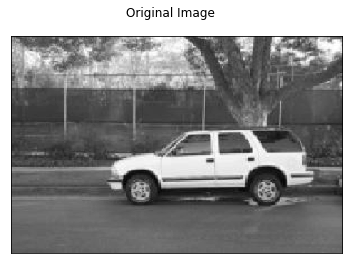

In [184]:
# show 
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
plt.suptitle('Original Image')
plt.show()

This is to provide hints for parameters in cv2.HoughCircles().

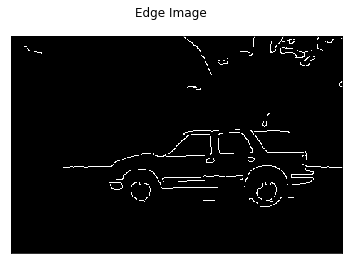

In [185]:
# gaussian filter to blur
blur = cv2.GaussianBlur(img,(7,7),0)
# canny edge detection
edges = cv2.Canny(blur, 100, 200, apertureSize = 3, L2gradient = True)

plt.imshow(edges, cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.suptitle('Edge Image')
plt.show()

In [186]:
print(blur)

[[105 105 105 ...  96  97  97]
 [108 108 108 ...  97  98  99]
 [117 117 116 ... 101 105 106]
 ...
 [ 90  91  91 ... 106 106 106]
 [ 90  91  91 ... 106 106 106]
 [ 90  91  91 ... 106 106 106]]


In [134]:
# hough circle detection
# first int 1 means the same resolution as the input image 
# minDist is the distance between nearby circle
# param1 is the maxVal for canny detection
# param2 is the accumulator threshold
circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT, 1, minDist = 120, param1=200,param2=20,minRadius=10,maxRadius=30)
circles = np.uint16(np.around(circles))
print(circles)

[[[358 214  12]
  [182 218  13]]]


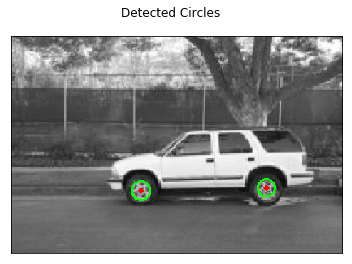

In [135]:
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(255,0,0),3)

# show image 
plt.imshow(cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.suptitle('Detected Circles')
plt.show()

### Apply Hough transform to nucleus detection

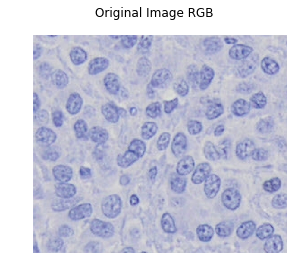

In [252]:
# show 
# This image is RGB
img = cv2.imread("P2_nuclei.png")

image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image)
plt.suptitle('Original Image RGB')
plt.show()

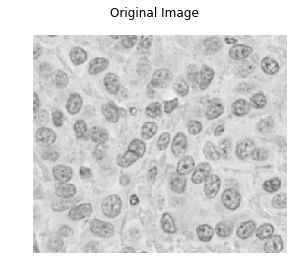

In [253]:
# grayscale
cimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(cimg, cmap = 'gray')
plt.show()

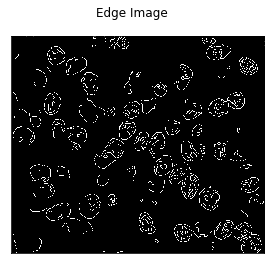

In [254]:
# gaussian filter to blur
blur = cv2.GaussianBlur(cimg,(5,5),0)
# canny edge detection
edges = cv2.Canny(blur, 40, 80, apertureSize = 3, L2gradient = True)

plt.imshow(edges, cmap = "gray")
plt.xticks([]), plt.yticks([]), plt.suptitle('Edge Image')
plt.show()

In [255]:
circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT, 1, minDist = 30, param1=80,param2=10,minRadius=15,maxRadius=30)
circles = np.uint16(np.around(circles))

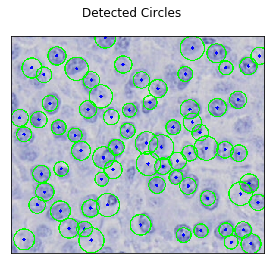

In [256]:
# This image is RGB
img = cv2.imread("P2_nuclei.png")
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(255,0,0),3)

# show image 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap = 'gray')
plt.xticks([]), plt.yticks([]), plt.suptitle('Detected Circles')
plt.show()

## Object segmentation using watershed transform.

### Coins Segmentation
Apply marker-controlled watershed to image segmentation for P3_coins.png. You might want to use the erosion morphology operation to find the markers. Please draw the segmented boundaries/contours on the original image and mark the contours with different colors, one per segment.

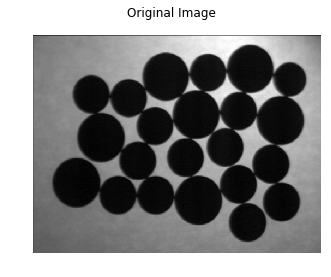

In [235]:
# This image is greyscale
# 0 means read as greyscale
img = cv2.imread("P3_coins.png",0)
plt.axis("off"), plt.suptitle('Original Image')
plt.imshow(img, cmap = 'gray')
plt.show()

## References